
    # Throughout this example, variables suffixed _dft are tables encoded as data frames.
    # Variables suffixed _dfm are matrices encoded as data frames.


In [20]:
# Read a CSV file associating installs with plugin + version.

import pandas as pd
plugins_csv = pd.read_csv('data/plugins_scrubbed.csv')
print(plugins_csv.columns)
print(plugins_csv.shape)

Index(['install_name', 'plugin_name', 'version'], dtype='object')
(3719805, 3)


In [2]:
# We are not going to differentiate plugins by version, so drop the column.

del plugins_csv['version']
print(plugins_csv.columns)

Index(['install_name', 'plugin_name'], dtype='object')


In [3]:
# the nnmf library looks for an association table with columns 'SUBJECT' and 'OBJECT'

import nnmf

plugins_dft = plugins_csv.rename(
    columns={'install_name': nnmf.SUBJECT_COLUMN_NAME, 
             'plugin_name': nnmf.OBJECT_COLUMN_NAME})

print(plugins_dft.columns)

Index(['SUBJECT', 'OBJECT'], dtype='object')


In [4]:
# now convert association table to a ratings (association) matrix...

# but first, we need to reduce the data size.
# use random sampling for time being -- we can do better than this.
# for example, find the most popular n plugins, and keep only those associations

#plugins_10k_dft = plugins_dft.sample(n=10*1000)
plugins_10k_dft = plugins_dft.head(n=10*1000)
plugins_dfm = nnmf.ratings_table_to_matrix(plugins_10k_dft)
print(f'Matrix has {plugins_dfm.size} cells: {plugins_dfm.shape}')

Matrix has 1075184 cells: (451, 2384)


In [5]:
# now we can build a cluster model
from nnmf.clustering import ClusterModel

model = ClusterModel()
model.clusters = 5
model.ratings_matrix = plugins_dfm

err = model.build()
print(f'Divergence is {err}')

Divergence is 68.07145853772992


In [6]:
%matplotlib inline

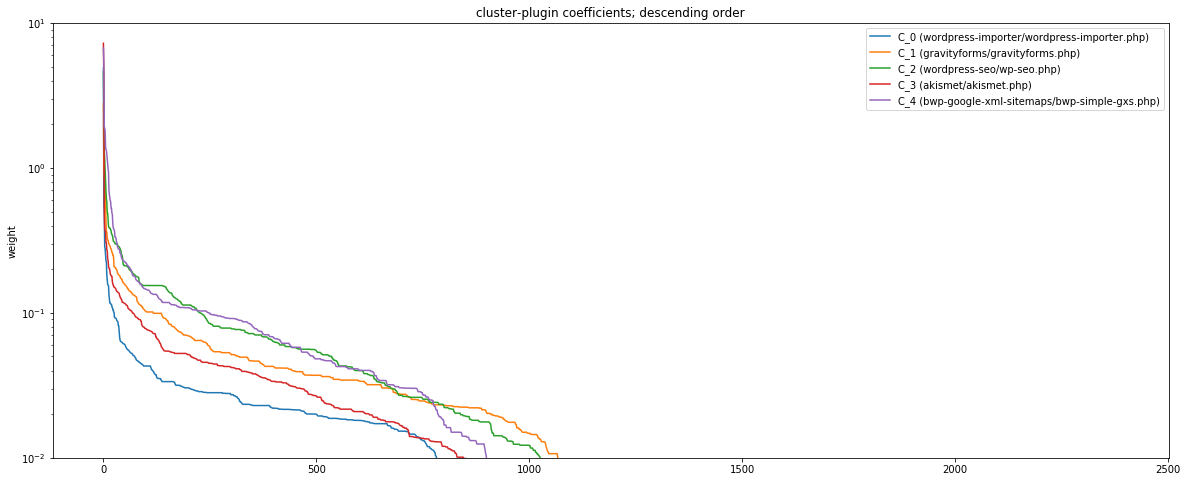

In [19]:
# lets do a quick check to see that the cluster-plugin coefficients show a clear cut-off
# eyeballing is the easiest way at this stage

import matplotlib.pyplot as plt

cp_coeff_dfm = model.object_cluster_dfm  # rows named by plugin; each column is a cluster.

plt.figure(figsize=(20, 8))  # sizes are in inches!
plt.title('cluster-plugin coefficients; descending order')
plt.ylabel('weight')
plt.yscale('log')
plt.ylim(ymin=0.01, ymax=10)
legend = []
for cn in model.cluster_names:
    weights = cp_coeff_dfm[cn].sort_values(ascending=False)
    plt.plot(weights.values)
    legend.append(f'{cn} ({weights.index[0]})')  # include the most prominent plugin in each cluster.

plt.legend(legend)
plt.show()